# **Import Libraries & Data Loading**

In [71]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
import plotly.express as px
from collections import Counter
from datetime import datetime

import sklearn
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

#Configure Visualization Defaults
#%matplotlib inline = show plots in Jupyter Notebook browser
%matplotlib inline
plt.style.use('ggplot')
sns.set_style('white')
plt.rcParams['figure.figsize'] = 12, 8

pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
pd.set_option("display.float_format", lambda x: "%.4f" % x)

In [72]:
def check_duplicates(dataframe):
    print("Duplicate Values (Top 10):")
    duplicate_values = dataframe[dataframe.duplicated()]
    print(f"Number of Duplicate Rows: {duplicate_values.shape[0]}")
    display(duplicate_values.head(10))

def missing_data(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

def basic_data_info(dataframe):
    print("Data Preview:")
    print("---------------------------")
    display(dataframe.head())

    print("\nGeneral Info:")
    print("---------------------------")
    print(dataframe.info())

    print("\nDescriptive Statistics:")
    print("---------------------------")
    display(dataframe.describe().T)

# **Import Data**

In [73]:
mainPath = "/content/drive/MyDrive/Colab Notebooks/5. Project [Data Bridge]/3. Clustering World Alcohol Consumption"

In [74]:
df = pd.read_csv(mainPath + "/Data/World Alcoholic Consumption datasets.csv")

# **Simply Explore The Data**

In [75]:
basic_data_info(df)

Data Preview:
---------------------------


,Gender,Count,Countries,Countries Code,Date
0,Female,1,Japan,JP,12/25/2019
1,Female,2,Czech Republic,CZ,12/22/2019
2,Male,3,Portugal,PT,12/28/2019
3,Female,4,Netherlands,NL,12-01-19
4,Female,5,Argentina,AR,12/24/2019



General Info:
---------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12500 entries, 0 to 12499
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Gender          12500 non-null  object
 1   Count           12500 non-null  int64 
 2   Countries       12500 non-null  object
 3   Countries Code  12491 non-null  object
 4   Date            12500 non-null  object
dtypes: int64(1), object(4)
memory usage: 488.4+ KB
None

Descriptive Statistics:
---------------------------


,count,mean,std,min,25%,50%,75%,max
Count,12500.0000,490.5000,288.5133,1.0000,241.0000,481.0000,740.0000,1000.0000


In [76]:
def missing_data(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

missing_data(df)

,Total,Percent
Countries Code,9,0.0720
Gender,0,0.0000
Count,0,0.0000
Countries,0,0.0000
Date,0,0.0000


In [77]:
check_duplicates(df)

Duplicate Values (Top 10):
Number of Duplicate Rows: 0


,Gender,Count,Countries,Countries Code,Date


# **Preprocessing Data**

In [78]:
df_clean = df.copy()

### Samakan Format Tanggal

In [79]:
# Tanggal dalam berbagai format
dates = df_clean['Date']

def convert_date(date_str):
    # Mencoba format tanggal yang berbeda
    formats = ["%m-%d-%y", "%m/%d/%Y"]
    for fmt in formats:
        try:
            return datetime.strptime(date_str, fmt).strftime("%m/%d/%Y")
        except ValueError:
            pass
    # Jika tidak ada format yang cocok, kembalikan None
    return None

# Konversi semua tanggal ke format yang sama
formatted_dates = [convert_date(date) for date in dates]

In [80]:
df_clean['Date'] = formatted_dates

### Feature Engineering [Month, Day, Year, Day_of_week]

In [81]:
# Pisahkan tanggal menjadi bulan, tanggal, dan tahun
df_clean[['Month', 'Day', 'Year']] = df_clean['Date'].str.split('/', expand=True)

# Gunakan indeks untuk mendapatkan hari dari tanggal
df_clean['Day_of_week'] = pd.to_datetime(df_clean['Date']).dt.day_name()

### Drop Kolom Countries Code & Date

In [82]:
df_clean = df_clean.drop(columns = ["Countries Code", "Date", "Count"])

### Convert tipe data

In [83]:
# Konversi kolom bulan, tanggal, dan tahun menjadi integer dengan applymap()
df_clean[['Month', 'Day', 'Year']] = df_clean[['Month', 'Day', 'Year']].applymap(int)

### Label Encoder for Categorical Feature

In [84]:
def label_encode_dataframe(df):
    label_encoders = {}
    # Label encode kolom non-numerik
    for column in df.columns:
        if df[column].dtype == 'object':
            label_encoders[column] = LabelEncoder()
            df[column] = label_encoders[column].fit_transform(df[column])

    return df

In [85]:
df_clean = label_encode_dataframe(df_clean)

In [86]:
# Ganti nilai 2019 dengan 1 dan nilai 2020 dengan 2 pada kolom "Year"
df_clean['Year'] = df_clean['Year'].replace({2019: 1, 2020: 2})

In [87]:
df_clean

,Gender,Countries,Month,Day,Year,Day_of_week
0,0,94,12,25,1,6
1,0,47,12,22,1,3
2,1,153,12,28,1,2
3,0,134,12,1,1,3
4,0,7,12,24,1,5
...,...,...,...,...,...,...
12495,1,158,11,9,1,2
12496,1,39,3,20,1,6
12497,1,39,4,21,1,3
12498,0,151,3,20,1,6


# **PCA (Principal Component Analysis)**

In [88]:
def perform_pca(dataframe, num_components):
    pca = PCA(n_components=num_components)
    transformed_data = pca.fit_transform(dataframe)

    # Buat DataFrame dengan kolom PCA-1, PCA-2, dst.
    column_names = [f'PCA-{i}' for i in range(1, num_components + 1)]
    hasil_pca = pd.DataFrame(data=transformed_data, columns=column_names)

    explained_variances = pca.explained_variance_ratio_
    total_explained_variance = sum(explained_variances)

    # Print rasio varians yang dijelaskan dan totalnya
    print("Explained variance ratios:")
    print(explained_variances)
    print("\nTotal explained variance:", total_explained_variance)
    print("Ukuran DataFrame hasil PCA:", hasil_pca.shape)

    return hasil_pca

In [89]:
hasil_pca = perform_pca(df_clean, num_components=3)

Explained variance ratios:
[0.97496999 0.0206983  0.00310503]

Total explained variance: 0.998773327295296
Ukuran DataFrame hasil PCA: (12500, 3)


In [90]:
# Hitung nilai minimum dan maksimum dari setiap kolom
rentang_data = {
    'PCA-1': (hasil_pca['PCA-1'].min(), hasil_pca['PCA-1'].max()),
    'PCA-2': (hasil_pca['PCA-2'].min(), hasil_pca['PCA-2'].max()),
    'PCA-3': (hasil_pca['PCA-3'].min(), hasil_pca['PCA-3'].max())
}

print("Rentang Data:")
for pca, rentang in rentang_data.items():
    print(f"{pca}: {rentang[0]} - {rentang[1]}")

Rentang Data:
PCA-1: -98.04381023755751 - 107.98526800486374
PCA-2: -14.514564458858372 - 15.671739539834606
PCA-3: -5.258487965346619 - 5.7869050713963155


# K-means

## Elbow Method

In [91]:
def plot_elbow_method(data, max_clusters=15):
    # Melakukan metode siku (elbow method) untuk pemilihan jumlah cluster menggunakan KMeans.
    inersia_values = []
    for i in range(1, max_clusters + 1):
        kmeans = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=300, random_state=0)
        kmeans.fit(data)
        inersia_values.append(kmeans.inertia_)

    # Plot Elbow Method with Labels
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, max_clusters + 1), inersia_values, marker='o', linestyle='-', color='b')

    # Menambahkan label untuk setiap titik data
    for i, inertia in enumerate(inersia_values):
        plt.text(i + 1.2, inertia, f'{inertia:.2f}', ha='left', va='bottom', fontsize=10)

    plt.title('Elbow Method for Optimal Clusters', fontsize=16)
    plt.xlabel('Number of Clusters', fontsize=14)
    plt.ylabel('Inertia Value', fontsize=14)
    plt.xticks(range(1, max_clusters + 1))
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

    return inersia_values

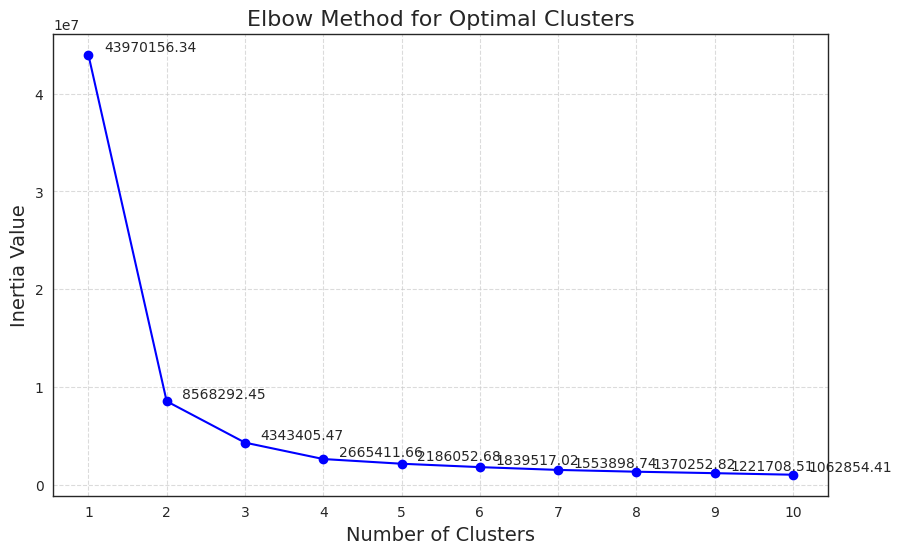

In [92]:
# Contoh penggunaan
inersia_values_df = plot_elbow_method(hasil_pca, max_clusters=10)

## Diferensisasi Inersia

In [93]:
def calculate_diff_inertia(inersia_values):
    result_diff_inersia = []
    for i in range(1, len(inersia_values)):
        diff = inersia_values[i] - inersia_values[i - 1]
        result_diff_inersia.append(abs(diff))

    # List untuk menyimpan hasil diff dan operasi pengurangan
    diff_list = []
    operation_list = []

    # Loop untuk menghitung perbedaan dan operasi pengurangan
    for i in range(1, len(inersia_values)):
        diff = inersia_values[i] - inersia_values[i - 1]
        diff_list.append(abs(diff))
        operation_list.append(f"{i} - {i - 1}")

    # Membuat DataFrame dari hasil perhitungan
    result_df = pd.DataFrame({'Diff': diff_list, 'Operation': operation_list})

    return result_df

In [94]:
# inersia_values df1
dif_df = calculate_diff_inertia(inersia_values_df).sort_values(by="Diff", ascending=False)

# K-Means with optimizer n-cluster

In [97]:
# Apply K-means clustering
km_optimaze_k = KMeans(random_state = 70, n_clusters = 3, init = 'k-means++', n_init = 'auto', max_iter = 150, tol = 0.0001)

In [98]:
km_optimaze_k.fit(hasil_pca)

KMeans(max_iter=150, n_clusters=3, n_init='auto', random_state=70)

In [99]:
predicted_labels = km_optimaze_k.labels_

In [100]:
# Mendapatkan koordinat centroid
centroids = km_optimaze_k.cluster_centers_

In [101]:
# Menggunakan Counter untuk menghitung kemunculan setiap nilai
label_counts = Counter(predicted_labels)
label_counts

Counter({2: 3132, 0: 4489, 1: 4879})

## Evaluasi Hasil Clustering

In [102]:
# Menghitung beberapa metrik evaluasi lainnya
silhouette = silhouette_score(hasil_pca, km_optimaze_k.labels_)
db_index = davies_bouldin_score(hasil_pca, km_optimaze_k.labels_)
ch_index = calinski_harabasz_score(hasil_pca, km_optimaze_k.labels_)

print(f"Silhouette Score: {silhouette}")
print(f"Davies-Bouldin Index: {db_index}")
print(f"Calinski-Harabasz Index: {ch_index}")

Silhouette Score: 0.6167503128198257
Davies-Bouldin Index: 0.5162493609707693
Calinski-Harabasz Index: 57007.745277774484


## Final Result untuk Hasil Clustering

### In Original Dataset

In [103]:
df_with_cluster_result = df.copy()
df_with_cluster_result['Cluster Result'] = predicted_labels

In [104]:
df_with_cluster_result

,Gender,Count,Countries,Countries Code,Date,Cluster Result
0,Female,1,Japan,JP,12/25/2019,2
1,Female,2,Czech Republic,CZ,12/22/2019,0
2,Male,3,Portugal,PT,12/28/2019,1
3,Female,4,Netherlands,NL,12-01-19,1
4,Female,5,Argentina,AR,12/24/2019,0
...,...,...,...,...,...,...
12495,Male,996,Russia,RU,11-09-19,1
12496,Male,997,China,CN,3/20/2019,0
12497,Male,998,China,CN,4/21/2019,0
12498,Female,999,Philippines,PH,3/20/2019,1


### In PCA Dataset

In [105]:
pca_with_cluster_result = hasil_pca.copy()
pca_with_cluster_result['Cluster Result'] = predicted_labels

In [106]:
pca_with_cluster_result

,PCA-1,PCA-2,PCA-3,Cluster Result
0,-4.0184,9.6005,5.7741,2
1,-51.0218,6.6455,5.7789,0
2,54.9841,12.5378,5.7721,1
3,35.9569,-14.4423,5.7655,1
4,-91.0195,8.6875,5.7821,0
...,...,...,...,...
12495,59.9649,-6.4670,4.7668,1
12496,-59.0241,4.6587,-3.2197,0
12497,-59.0234,5.6560,-2.2183,0
12498,52.9758,4.5455,-3.2306,1


# Plot Cluster K-Means Result

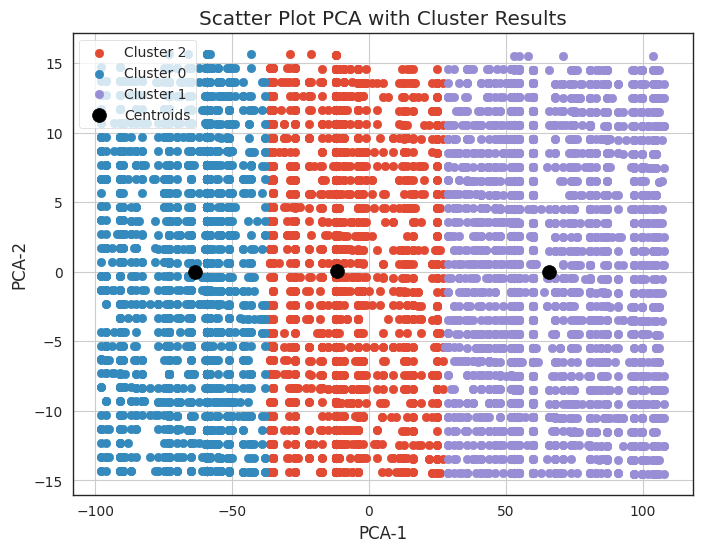

In [107]:
import matplotlib.pyplot as plt

# Buat scatter plot untuk PCA dengan memberikan warna sesuai dengan hasil klastering
plt.figure(figsize=(8, 6))
for cluster_label in pca_with_cluster_result['Cluster Result'].unique():
    plt.scatter(
        hasil_pca.loc[pca_with_cluster_result['Cluster Result'] == cluster_label, 'PCA-1'],
        hasil_pca.loc[pca_with_cluster_result['Cluster Result'] == cluster_label, 'PCA-2'],
        label=f'Cluster {cluster_label}'
    )

# Plot centroids
plt.scatter(centroids[:, 0], centroids[:, 1], marker='o', s=100, c='black', label='Centroids')

plt.xlabel('PCA-1')
plt.ylabel('PCA-2')
plt.title('Scatter Plot PCA with Cluster Results')
plt.legend()
plt.grid(True)
plt.show()

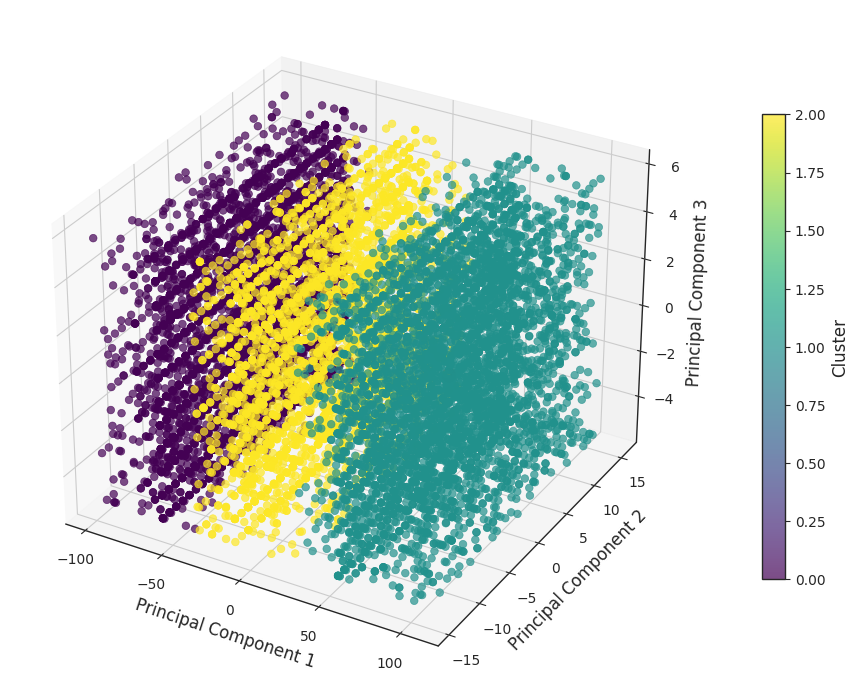

In [108]:
from mpl_toolkits.mplot3d import Axes3D

# Data
atribut1 = pca_with_cluster_result['PCA-1']
atribut2 = pca_with_cluster_result['PCA-2']
atribut3 = pca_with_cluster_result['PCA-3']
cluster = pca_with_cluster_result['Cluster Result']

# Membuat scatter plot 3D dengan Matplotlib
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot dengan warna berdasarkan kluster
scatter = ax.scatter(atribut1, atribut2, atribut3, c=cluster, cmap='viridis', s=30, alpha=0.7)

# Plot centroids
ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2], marker='o', c='red', s=100, label='Centroids')

# Menambahkan label pada sumbu-sumbu
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')

# Set proporsi sumbu dengan penyesuaian tinggi
ax.set_box_aspect([1, 1, 0.8])  # [width, height, depth]

# Menambahkan colorbar dengan penyesuaian tinggi dan posisi
cbar = plt.colorbar(scatter, ax=ax, fraction=0.03, pad=0.1, aspect=20)
cbar.set_label('Cluster')

# Menampilkan plot
plt.show()

In [109]:
import plotly.graph_objects as go

# Data
atribut1 = pca_with_cluster_result['PCA-1']
atribut2 = pca_with_cluster_result['PCA-2']
atribut3 = pca_with_cluster_result['PCA-3']
cluster = pca_with_cluster_result['Cluster Result']

# Create 3D scatter plot using Plotly Express
fig = px.scatter_3d(x=atribut1, y=atribut2, z=atribut3, color=cluster, title='3D Scatter Plot with Clusters')

# Add centroids
centroid_df = pd.DataFrame(centroids, columns=['PCA-1', 'PCA-2', 'PCA-3'])
fig.add_trace(go.Scatter3d(x=centroid_df['PCA-1'],
                            y=centroid_df['PCA-2'],
                            z=centroid_df['PCA-3'],
                            mode='markers',
                            marker=dict(size=15, color='black', symbol='circle'),
                            name='Centroids'))

# Update layout for better visualization
fig.update_layout(scene=dict(
                    xaxis_title='Principal Component 1',
                    yaxis_title='Principal Component 2',
                    zaxis_title='Principal Component 3'),
                  margin=dict(l=0, r=0, b=0, t=30))

# Show plot
fig.show()

# (EDA - Exploratory Data Analysis) What Cluster Insight We Can Get?

In [110]:
df_with_cluster_result.head()

,Gender,Count,Countries,Countries Code,Date,Cluster Result
0,Female,1,Japan,JP,12/25/2019,2
1,Female,2,Czech Republic,CZ,12/22/2019,0
2,Male,3,Portugal,PT,12/28/2019,1
3,Female,4,Netherlands,NL,12-01-19,1
4,Female,5,Argentina,AR,12/24/2019,0


In [111]:
# Tanggal dalam berbagai format
dates = df_with_cluster_result['Date']

def convert_date(date_str):
    # Mencoba format tanggal yang berbeda
    formats = ["%m-%d-%y", "%m/%d/%Y"]
    for fmt in formats:
        try:
            return datetime.strptime(date_str, fmt).strftime("%m/%d/%Y")
        except ValueError:
            pass
    # Jika tidak ada format yang cocok, kembalikan None
    return None

# Konversi semua tanggal ke format yang sama
formatted_dates = [convert_date(date) for date in dates]

In [112]:
df_with_cluster_result['Date'] = formatted_dates

In [113]:
df_with_cluster_result = df_with_cluster_result.drop(columns = ["Countries Code", "Count"])

In [114]:
# Pisahkan tanggal menjadi bulan, tanggal, dan tahun
df_with_cluster_result[['Month', 'Day', 'Year']] = df_with_cluster_result['Date'].str.split('/', expand=True)

# Gunakan indeks untuk mendapatkan hari dari tanggal
df_with_cluster_result['Day_of_week'] = pd.to_datetime(df_with_cluster_result['Date']).dt.day_name()

In [115]:
df_with_cluster_result.columns

Index(['Gender', 'Countries', 'Date', 'Cluster Result', 'Month', 'Day', 'Year',
       'Day_of_week'],
      dtype='object')

In [116]:
df_with_cluster_result[['Gender', 'Countries', 'Date', 'Month', 'Day', 'Year', 'Day_of_week', 'Cluster Result']]

,Gender,Countries,Date,Month,Day,Year,Day_of_week,Cluster Result
0,Female,Japan,12/25/2019,12,25,2019,Wednesday,2
1,Female,Czech Republic,12/22/2019,12,22,2019,Sunday,0
2,Male,Portugal,12/28/2019,12,28,2019,Saturday,1
3,Female,Netherlands,12/01/2019,12,01,2019,Sunday,1
4,Female,Argentina,12/24/2019,12,24,2019,Tuesday,0
...,...,...,...,...,...,...,...,...
12495,Male,Russia,11/09/2019,11,09,2019,Saturday,1
12496,Male,China,03/20/2019,03,20,2019,Wednesday,0
12497,Male,China,04/21/2019,04,21,2019,Sunday,0
12498,Female,Philippines,03/20/2019,03,20,2019,Wednesday,1


## Top 10 Alcoholic Countries by Female and Male

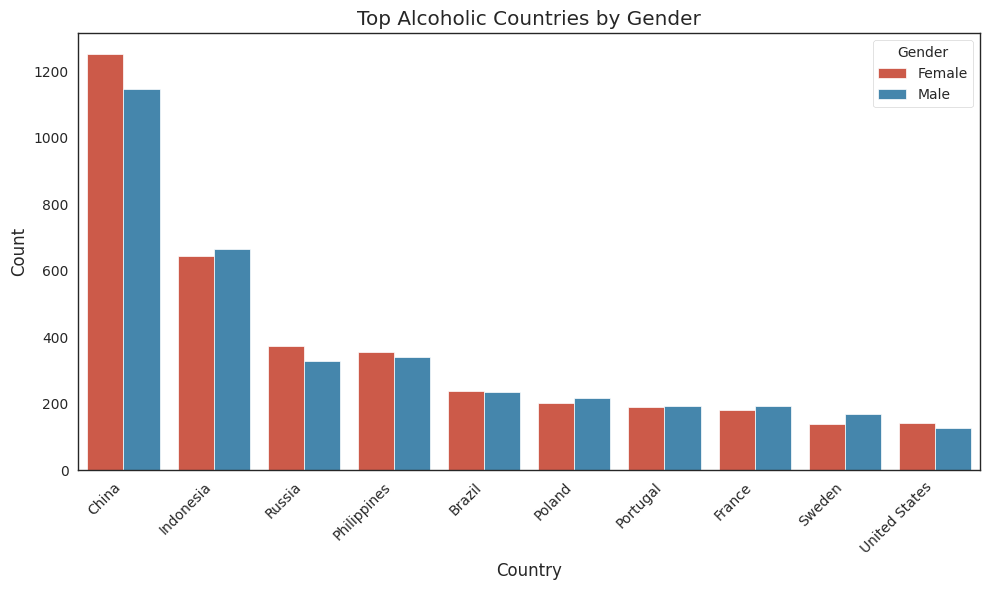

In [117]:
# Menghitung jumlah entri per negara berdasarkan Gender
top_countries = df_with_cluster_result.groupby(['Gender', 'Countries']).size().reset_index(name='Count')

# Memilih top alcoholic countries per Gender
top_countries = top_countries.sort_values(by='Count', ascending=False).groupby('Gender').head(10)

# Membuat plot
plt.figure(figsize=(10, 6))
sns.barplot(data=top_countries, x='Countries', y='Count', hue='Gender', dodge=True)
plt.xlabel('Country')
plt.ylabel('Count')
plt.title('Top Alcoholic Countries by Gender')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Gender')
plt.tight_layout()
plt.show()

## Top 5 Alcoholic Countries by Cluster Result

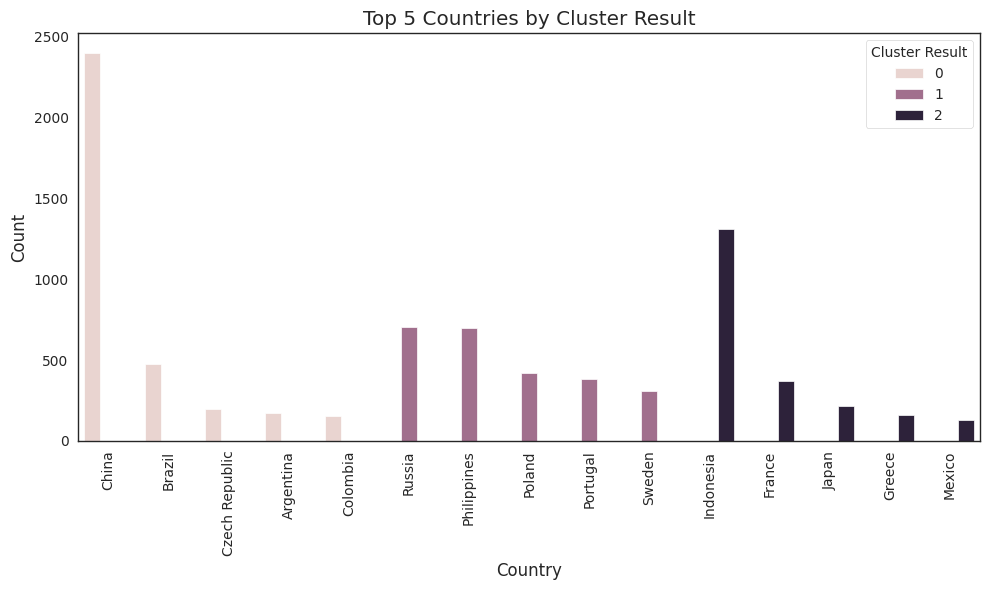

In [118]:
# Menghitung jumlah entri per negara berdasarkan 'Countries' dan 'Cluster Result'
top_countries = df_with_cluster_result.groupby(['Countries', 'Cluster Result']).size().reset_index(name='Count')

# Memilih top 10 negara dengan jumlah entri terbanyak per 'Cluster Result'
top_countries = top_countries.groupby('Cluster Result').apply(lambda x: x.nlargest(5, 'Count')).reset_index(drop=True)

# Memplot hasilnya
plt.figure(figsize=(10, 6))
sns.barplot(data=top_countries, x='Countries', y='Count', hue='Cluster Result', dodge=True)
plt.xlabel('Country')
plt.ylabel('Count')
plt.title('Top 5 Countries by Cluster Result')
plt.xticks(rotation=90)
plt.legend(title='Cluster Result')
plt.tight_layout()
plt.show()

In [139]:
top_countries

,Countries,Cluster Result,Count
0,China,0,2398
1,Brazil,0,475
2,Czech Republic,0,200
3,Argentina,0,174
4,Colombia,0,154
5,Russia,1,705
6,Philippines,1,697
7,Poland,1,419
8,Portugal,1,385
9,Sweden,1,309


## Year with highest alcohol consumption

In [119]:
# Menghitung jumlah entri per tahun
yearly_consumption = df_with_cluster_result.groupby('Year').size().reset_index(name='Total Consumption')

# Mendapatkan tahun dengan konsumsi alkohol tertinggi
year_with_highest_consumption = yearly_consumption.loc[yearly_consumption['Total Consumption'].idxmax()]

print("Year with highest alcohol consumption:", year_with_highest_consumption['Year'])

Year with highest alcohol consumption: 2020


In [123]:
yearly_consumption

,Year,Total Consumption
0,2019,1500
1,2020,11000


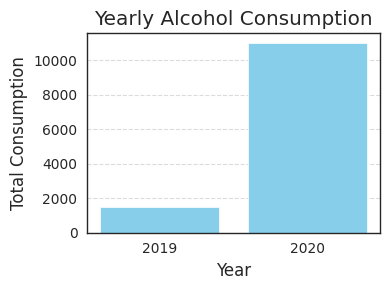

In [122]:
# Plot
plt.figure(figsize=(4, 3))
plt.bar(yearly_consumption['Year'], yearly_consumption['Total Consumption'], color='skyblue')
plt.xlabel('Year')
plt.ylabel('Total Consumption')
plt.title('Yearly Alcohol Consumption')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Month with highest alcohol consumption

In [125]:
# Menghitung jumlah entri per bulan
monthly_consumption = df_with_cluster_result.groupby('Month').size().reset_index(name='Total Consumption')

# Mendapatkan bulan dengan konsumsi alkohol tertinggi
month_with_highest_consumption = monthly_consumption.loc[monthly_consumption['Total Consumption'].idxmax()]

print("Month with highest alcohol consumption:", month_with_highest_consumption['Month'])

Month with highest alcohol consumption: 05


In [127]:
monthly_consumption

,Month,Total Consumption
0,01,1064
1,02,1100
2,03,1085
3,04,1108
4,05,1110
5,06,1082
6,07,1094
7,08,1082
8,09,1095
9,10,1100


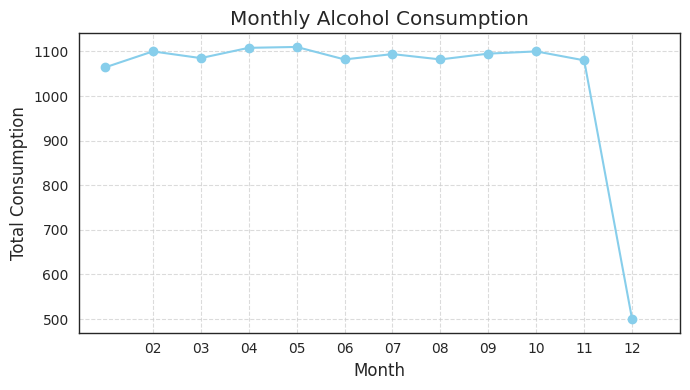

In [128]:
# Plot
plt.figure(figsize=(7, 4))
plt.plot(monthly_consumption['Month'], monthly_consumption['Total Consumption'], marker='o', color='skyblue', linestyle='-')
plt.xlabel('Month')
plt.ylabel('Total Consumption')
plt.title('Monthly Alcohol Consumption')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(range(1, 13))
plt.tight_layout()
plt.show()

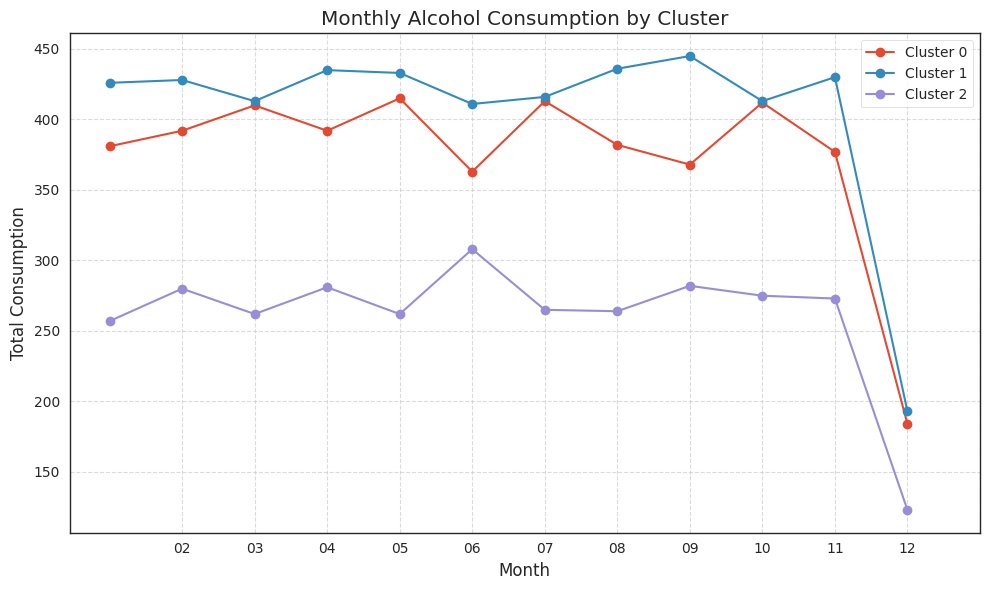

In [129]:
# Menghitung jumlah entri per bulan dan cluster
monthly_consumption_cluster = df_with_cluster_result.groupby(['Cluster Result', 'Month']).size().reset_index(name='Total Consumption')

# Plot
plt.figure(figsize=(10, 6))

for cluster in monthly_consumption_cluster['Cluster Result'].unique():
    cluster_data = monthly_consumption_cluster[monthly_consumption_cluster['Cluster Result'] == cluster]
    plt.plot(cluster_data['Month'], cluster_data['Total Consumption'], marker='o', label=f'Cluster {cluster}')

plt.xlabel('Month')
plt.ylabel('Total Consumption')
plt.title('Monthly Alcohol Consumption by Cluster')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(range(1, 13))
plt.legend()
plt.tight_layout()
plt.show()

In [140]:
monthly_consumption_cluster

,Cluster Result,Month,Total Consumption
0,0,01,381
1,0,02,392
2,0,03,410
3,0,04,392
4,0,05,415
5,0,06,363
6,0,07,413
7,0,08,382
8,0,09,368
9,0,10,412


## Gender that drinks the most alcohol based on its cluster

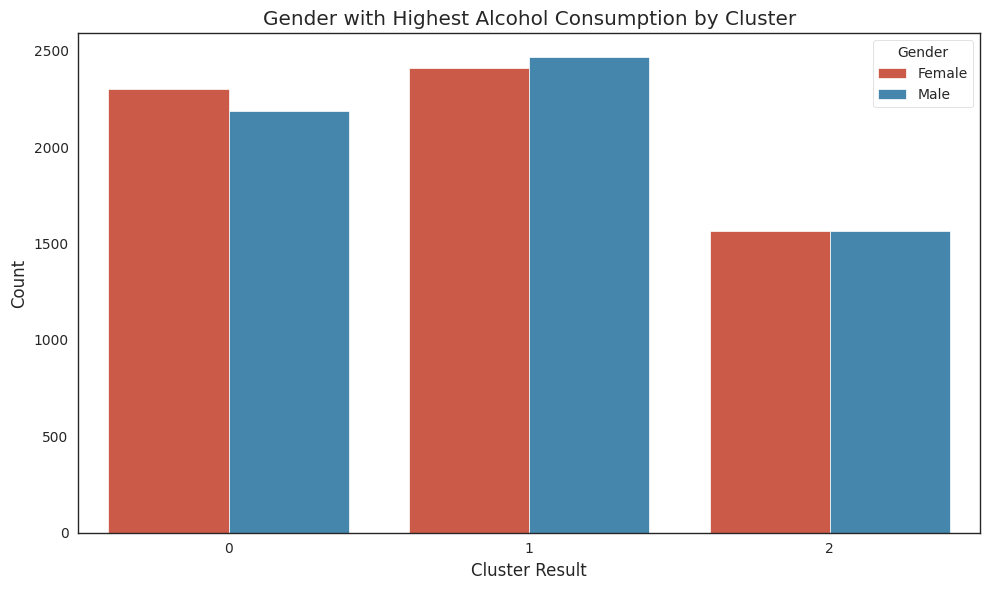

In [137]:
# Menghitung jumlah entri untuk setiap gender dalam setiap cluster
gender_counts = df_with_cluster_result.groupby(['Cluster Result', 'Gender']).size().reset_index(name='Count')

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=gender_counts, x='Cluster Result', y='Count', hue='Gender')
plt.title('Gender with Highest Alcohol Consumption by Cluster')
plt.xlabel('Cluster Result')
plt.ylabel('Count')
plt.legend(title='Gender')
plt.tight_layout()
plt.show()

In [142]:
gender_counts

,Cluster Result,Gender,Count
0,0,Female,2304
1,0,Male,2185
2,1,Female,2412
3,1,Male,2467
4,2,Female,1565
5,2,Male,1567


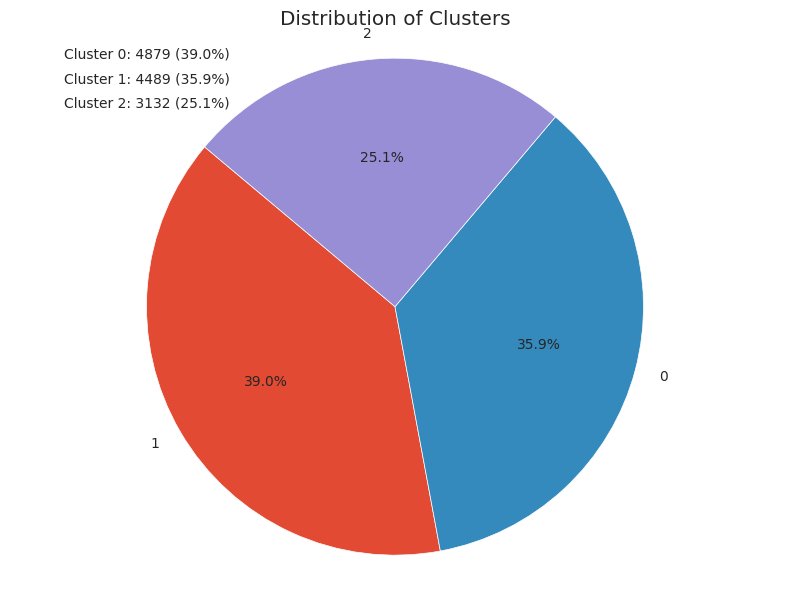

In [150]:
# Hitung jumlah entri untuk setiap kluster
cluster_counts = df_with_cluster_result['Cluster Result'].value_counts()

# Plot
plt.figure(figsize=(8, 6))
plt.pie(cluster_counts, labels=cluster_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Clusters')
# Menambahkan jumlah entri per kluster di sekitar diagram pie
for i, count in enumerate(cluster_counts):
    plt.text(-1, 1-i*0.1, f"Cluster {i}: {count} ({count/len(df)*100:.1f}%)", fontsize=10, ha='center')
plt.axis('equal')  # Membuat lingkaran agar terlihat proporsional
plt.tight_layout()
plt.show()